# Stochastic Block Models for Community Detection

This tutorial explores **Stochastic Block Models (SBMs)**, a generative approach to community detection in networks. We'll cover:

1. The theory behind stochastic block models
2. How to generate networks with community structure using SBMs
3. Fitting SBMs to empirical networks to discover communities
4. A detailed case study using Zachary's Karate Club dataset

## Introduction to Stochastic Block Models

Stochastic Block Models represent a powerful model-based approach to community detection. Unlike algorithms that directly partition networks (like Louvain or Label Propagation), SBMs:

- Provide a **generative model** of networks with community structure
- Allow **statistical inference** of community assignments
- Enable model selection to determine the optimal number of communities
- Can be extended to model various network structures (overlapping communities, hierarchical structures, etc.)

The core idea is simple but powerful: nodes are divided into groups, and the probability of connection between any two nodes depends only on their group memberships.

## 1. The Mathematics Behind Stochastic Block Models

### Basic SBM Formulation

A Stochastic Block Model is defined by:

1. **Block structure**: A partition of $n$ nodes into $k$ blocks (communities)
2. **Connectivity matrix**: A $k \times k$ matrix $P$ where $P_{rs}$ gives the probability of an edge between a node in block $r$ and a node in block $s$

Formally, for a network with adjacency matrix $A$ where $A_{ij} = 1$ if there's an edge between nodes $i$ and $j$:

- Each node $i$ belongs to a block $g_i \in \{1,2,...,k\}$
- The probability of an edge between nodes $i$ and $j$ is:
  $$P(i \leftrightarrow j) = P(A_{ij} = 1) = p_{g_i g_j}$$

The likelihood of observing a particular network given block assignments is:

$$P(A|g,P) = \prod_{i<j} p_{g_i g_j}^{A_{ij}} (1-p_{g_i g_j})^{1-A_{ij}}$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx

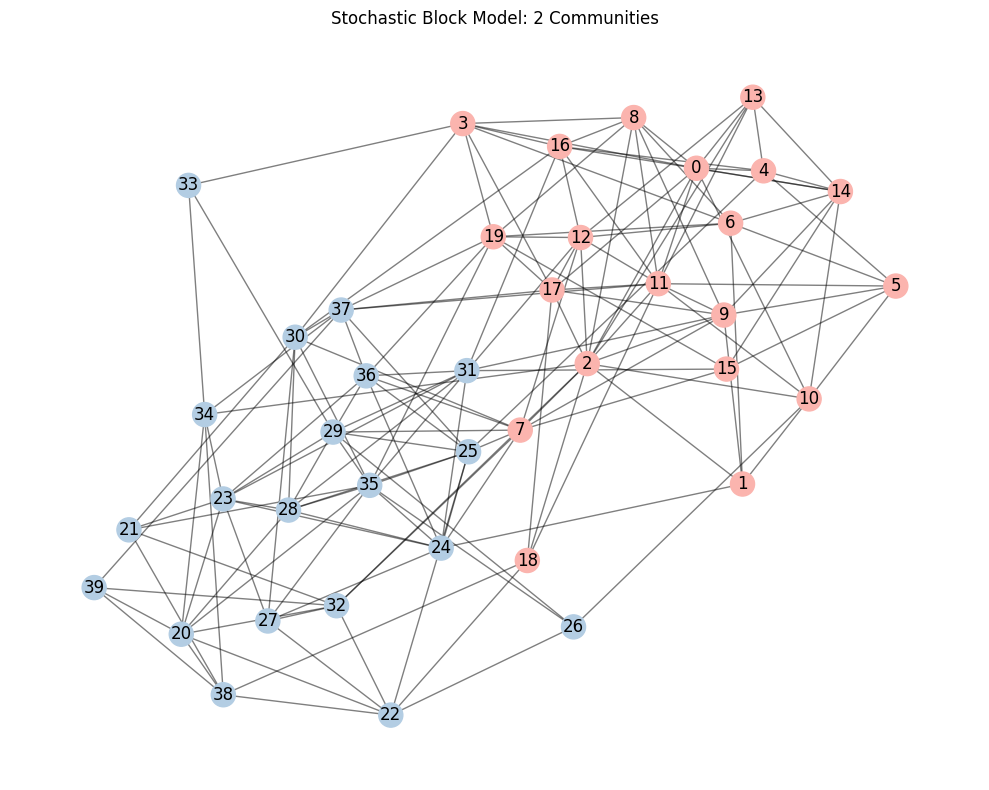

In [7]:
def generate_sbm_network(n_blocks, block_sizes, p_matrix, directed=False):
    """
    Generate a network using NetworkX's Stochastic Block Model implementation
    
    Parameters:
    -----------
    n_blocks : int
        Number of blocks (communities)
    block_sizes : list
        List of sizes for each block
    p_matrix : numpy.ndarray
        Probability matrix where p_matrix[i,j] is the connection probability
        between nodes in block i and block j
    directed : bool
        Whether to create a directed graph
    
    Returns:
    --------
    G : networkx.Graph
        The generated graph
    node_communities : dict
        Dictionary mapping node IDs to their true community assignments
    """
    # Check inputs
    assert len(block_sizes) == n_blocks, "Number of blocks must match length of block_sizes"
    assert p_matrix.shape == (n_blocks, n_blocks), "p_matrix must be n_blocks x n_blocks"
    
    # Generate the SBM graph using NetworkX's built-in function
    G = nx.stochastic_block_model(block_sizes, p_matrix, directed=directed, seed=42)
    
    # Store true community assignments
    node_communities = {}
    start_idx = 0
    for block_idx, size in enumerate(block_sizes):
        for offset in range(size):
            node_communities[start_idx + offset] = block_idx
        start_idx += size
    
    # Add true community as node attribute
    nx.set_node_attributes(G, node_communities, 'true_block')
    
    return G, node_communities

# Example 1: Simple 2-community structure
# Higher probability of connection within communities, lower between communities
n_blocks = 2
block_sizes = [20, 20]  # Two communities of 20 nodes each
# Probability matrix: p_matrix[i,j] = probability of edge between groups i and j
p_matrix = np.array([
    [0.3, 0.05],  # Group 0 connects to itself with p=0.3, to group 1 with p=0.05
    [0.05, 0.3]   # Group 1 connects to group 0 with p=0.05, to itself with p=0.3
])

# Generate the graph
G_2comm, true_comm_2 = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_2comm, seed=42)  # For consistent layout

# Color nodes by their true community
colors = plt.cm.Pastel1(np.array([true_comm_2[node] for node in G_2comm.nodes()]))

nx.draw_networkx_nodes(G_2comm, pos, node_color=colors, node_size=300)
nx.draw_networkx_edges(G_2comm, pos, alpha=0.5)
nx.draw_networkx_labels(G_2comm, pos)

plt.title("Stochastic Block Model: 2 Communities")
plt.axis("off")
plt.tight_layout()
plt.show()

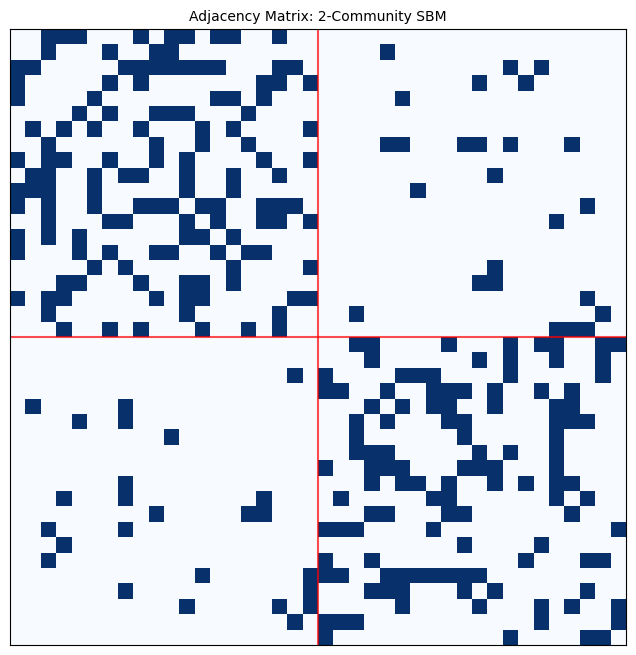

In [8]:
def plot_adjacency_matrix(G, node_communities, title, ax=None):
    """Plot the adjacency matrix with nodes ordered by community"""
    # Get the adjacency matrix
    A = nx.to_numpy_array(G)
    
    # Get the node order by community
    nodes = list(G.nodes())
    community_to_nodes = {}
    for node, comm in node_communities.items():
        if comm not in community_to_nodes:
            community_to_nodes[comm] = []
        community_to_nodes[comm].append(node)
    
    # Create ordered list of nodes
    ordered_nodes = []
    for comm in sorted(community_to_nodes.keys()):
        ordered_nodes.extend(sorted(community_to_nodes[comm]))
    
    # Reorder adjacency matrix
    idx = [nodes.index(node) for node in ordered_nodes]
    A_ordered = A[np.ix_(idx, idx)]
    
    # Create a new figure if ax is not provided
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    # Plot
    im = ax.imshow(A_ordered, cmap='Blues', interpolation='none')
    
    # Add lines to separate communities
    offset = 0
    for comm in sorted(community_to_nodes.keys()):
        offset += len(community_to_nodes[comm])
        if offset < len(nodes):
            ax.axhline(y=offset-0.5, color='red', linestyle='-', alpha=0.7)
            ax.axvline(x=offset-0.5, color='red', linestyle='-', alpha=0.7)
    
    ax.set_title(title, fontsize=10)
    # Remove ticks for cleaner appearance in subplots
    ax.set_xticks([])
    ax.set_yticks([])
    
    return im

# Plot adjacency matrix for 2-community SBM
plot_adjacency_matrix(G_2comm, true_comm_2, "Adjacency Matrix: 2-Community SBM")

In [9]:
n_blocks = 2 
block_sizes = [20, 20]

# 1. COMMUNITY STRUCTURE (Assortative)
# Higher probability of connection within communities, lower between communities
p_matrix = np.array([
    [0.3, 0.05],  # Group 0 connects to itself with p=0.3, to group 1 with p=0.05
    [0.05, 0.3]   # Group 1 connects to group 0 with p=0.05, to itself with p=0.3
])
G_assortative, true_comm_assortative = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# 2. DISASSORTATIVE STRUCTURE
# Links are more likely between communities than within them
p_matrix = np.array([
    [0.05, 0.3],  # Low probability within group 0, high between 0 and 1
    [0.3, 0.05]   # High probability between 1 and 0, low within group 1
])

G_disassortative, true_comm_disassortative = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# 3. MULTIPARTITE STRUCTURE (Bipartite as a special case)
# No connections within communities, only between
p_matrix = np.array([
    [0.0, 0.3],  # No connections within group 0, connections between 0 and 1
    [0.3, 0.0]   # Connections between 1 and 0, no connections within group 1
])

G_bipartite, true_comm_bipartite = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# 4. CORE-PERIPHERY STRUCTURE
# Core nodes are densely connected to each other and to periphery
# Periphery nodes are sparsely connected among themselves
p_matrix = np.array([
    [0.7, 0.2],  # Core-core connections very likely, core-periphery moderately likely
    [0.2, 0.05]  # Periphery-core moderately likely, periphery-periphery unlikely
])

G_core_periphery, true_comm_core_periphery = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# 5. RANDOM NETWORK
# All connection probabilities are the same regardless of community

p = 0.2  # Uniform probability of connection
p_matrix = np.array([
    [p, p],  # Same probability everywhere
    [p, p]
])

G_random, true_comm_random = generate_sbm_network(n_blocks, block_sizes, p_matrix)


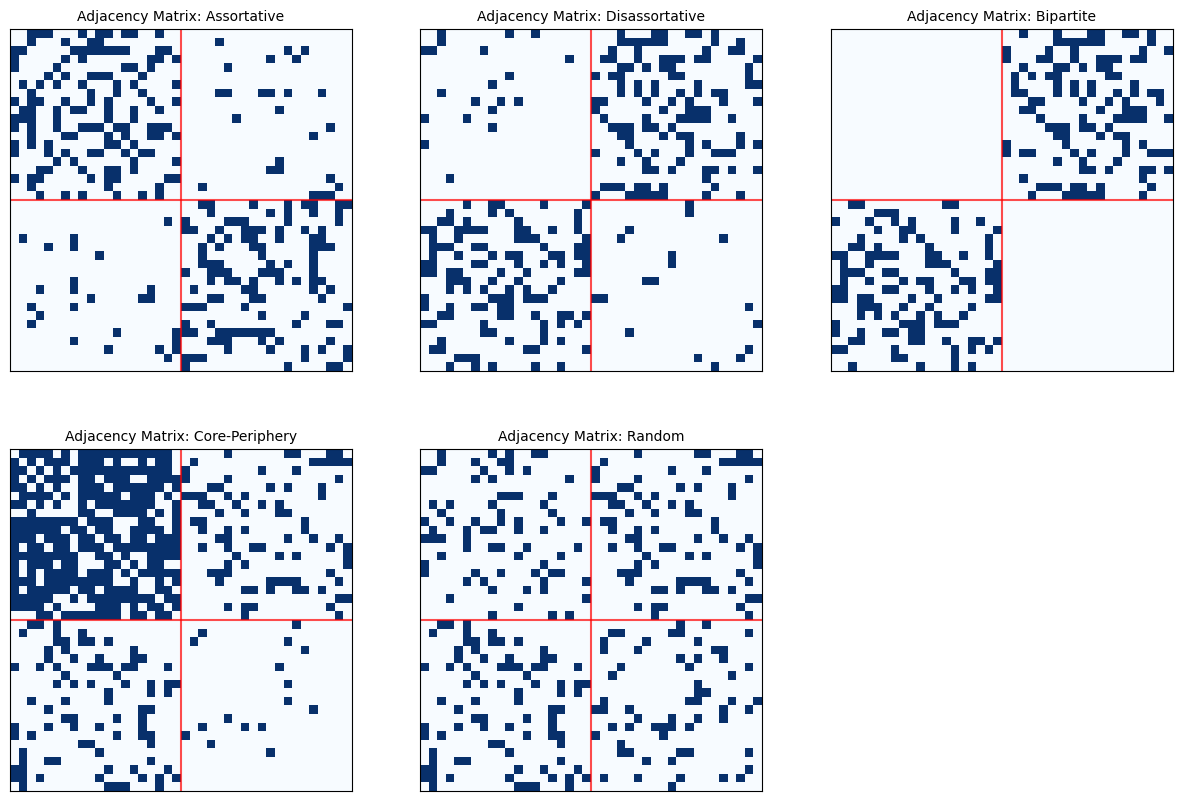

In [ ]:
# Plotting all adjacency matrices
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()         

plot_adjacency_matrix(G_assortative, true_comm_assortative, "Adjacency Matrix: Community", ax=axs[0])
plot_adjacency_matrix(G_disassortative, true_comm_disassortative, "Adjacency Matrix: Disassortative", ax=axs[1])
plot_adjacency_matrix(G_bipartite, true_comm_bipartite, "Adjacency Matrix: Bipartite", ax=axs[2])
plot_adjacency_matrix(G_core_periphery, true_comm_core_periphery, "Adjacency Matrix: Core-Periphery", ax=axs[3])
plot_adjacency_matrix(G_random, true_comm_random, "Adjacency Matrix: Random", ax=axs[4])
axs[5].axis('off')  # Empty subplot
plt.show()

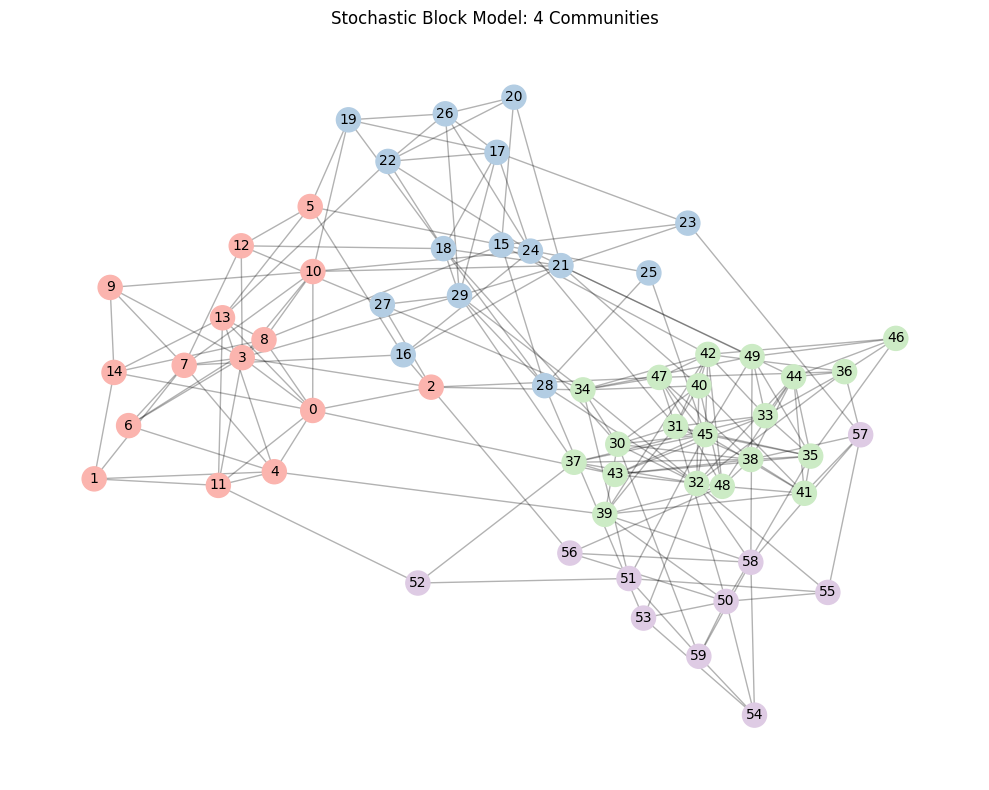

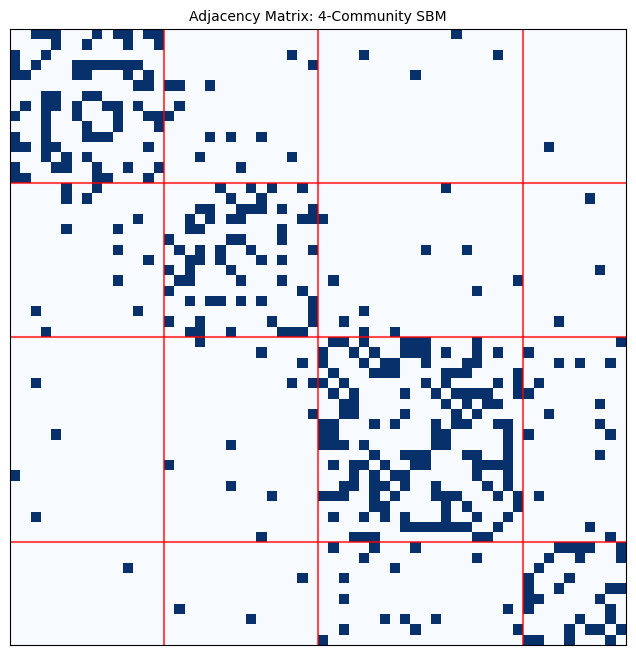

In [11]:
# Example 2: Creating a more complex 4-community structure
n_blocks = 4
block_sizes = [15, 15, 20, 10]  # Four communities of different sizes

# Create a probability matrix with community structure
# Diagonal elements (within-community) have higher probabilities
p_matrix = np.array([
    [0.3, 0.05, 0.02, 0.01],
    [0.05, 0.25, 0.03, 0.02],
    [0.02, 0.03, 0.35, 0.04],
    [0.01, 0.02, 0.04, 0.3]
])

# Generate the graph
G_4comm, true_comm_4 = generate_sbm_network(n_blocks, block_sizes, p_matrix)

# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_4comm, seed=42)

# Color nodes by their true community
community_colors = plt.cm.Pastel1(np.array([true_comm_4[node] for node in G_4comm.nodes()]))

nx.draw_networkx_nodes(G_4comm, pos, node_color=community_colors, node_size=300)
nx.draw_networkx_edges(G_4comm, pos, alpha=0.3)
nx.draw_networkx_labels(G_4comm, pos, font_size=10)

plt.title("Stochastic Block Model: 4 Communities")
plt.axis("off")
plt.tight_layout()
plt.show()

# Plot adjacency matrix for 4-community SBM
plot_adjacency_matrix(G_4comm, true_comm_4, "Adjacency Matrix: 4-Community SBM")

## 4. Conclusion and Further Directions

### Advanced Extensions

1. **Overlapping communities**: Methods that allow nodes to belong to multiple communities
2. **Hierarchical community structure**: Detecting nested communities at different scales
3. **Dynamic communities**: Detecting communities in temporal networks
4. **Mixed-membership models**: Allowing nodes to have partial membership in multiple communities

### Recommended Resources

1. **Books**:
   - "Networks: An Introduction" by Mark Newman
   - "Statistical Analysis of Network Data" by Eric D. Kolaczyk

2. **Software**:
   - NetworkX: Python network analysis library with community detection algorithms
   - graph-tool: High-performance Python library with extensive SBM implementations
   - cdlib: Python library for community detection

3. **Key Papers**:
   - "Stochastic blockmodels and community structure in networks" by Karrer & Newman (2011)
   - "Bayesian community detection" by Hofman & Wiggins (2008)
   - "Statistical inference of assortative community structures" by Zhang & Moore (2014)